### Pretraining on unlabeled data

In [12]:
#!pip install tiktoken
#!pip install tensorflow torch
#!pip install matplotlib

In [13]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    'numpy',
    'tiktoken',
    'torch',
    'tensorflow'
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 2.1.3
tiktoken version: 0.9.0
torch version: 2.5.1
tensorflow version: 2.19.0


### 5.1.1 Using GPT to generate text

In [14]:
import torch
from gpt import GPTModel

GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":256,
    "emb_dim": 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # Disable dropout durning inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [15]:
import tiktoken
from gpt import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text,allowed_special = {"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimesnions
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove the batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

In [16]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [17]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)  # probability of each token in vocabulary
print(probas.shape)  #(batch_size, num_tokens, vocab_size)



torch.Size([2, 3, 50257])


In [18]:
token_ids = torch.argmax(probas, dim =-1, keepdim=True)
print('Token ID: \n', token_ids)

Token ID: 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [19]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Output batch 1:  Armed heNetflix


In [20]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2: tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


In [21]:
# Compute logratithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5045, -10.3798, -11.3674, -11.4792,  -9.7771, -12.2549])


In [22]:
# calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7938)


In [23]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7938)


In [24]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [25]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print('Flattened logits:',logits_flat.shape)
print('Flattened targets:', targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [26]:
# apply the cross_entropy 
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7938)


In [27]:
# perplexity is simply the exponential of the cross-entropy loss
# It measure of how well the probability distribution predicated by the model matches the actual 
# actual distribution of the words in the dataset
perplexity = torch.exp(loss)
print(perplexity)

tensor(48717.6914)


### 5.1.3 Calculating the traning and validation set losses

In [28]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write((text_data))
else:
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.read()

In [29]:
# First 100 character
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [30]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [31]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [32]:
from gpt import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [33]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [34]:
print('Train loader:')
for x, y in train_loader:
    print(x.shape, y.shape)

print('\nValidation loader:')
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [35]:
# checking the token size
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Traning tokens: ", train_tokens)
print("Validation tokens: ", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Traning tokens:  4608
Validation tokens:  512
All tokens: 5120


In [36]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) ==0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        
        else:
            break
    
    return total_loss/num_batches


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print('Traning loss: ', train_loss)
print('Validation loss: ', val_loss)

Traning loss:  10.987385114034018
Validation loss:  10.980905532836914


### 5.2 Traning an LLM

In [38]:
def train_model_sample(model,train_loader,val_loader,optimizer,device,num_epoches,eval_freq,eval_iter,start_context,tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1

    #Main traning loop
    for epoch in range(num_epoches):
        model.train()    # set to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #calculate loss gradients
            optimizer.step() #update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq ==0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"EP {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, val loss {val_loss:.3f}")

    # Print a sample text after each epochs
    generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device,num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model,
            idx = encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n',' ')) # compact print format
    model.train()

In [39]:
# start the llm training
import time
start_time = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, token_seen = train_model_sample(
    model, train_loader, val_loader, optimizer, device,num_epoches=num_epochs, eval_freq=5, eval_iter=5,
    start_context='Every effort moves you', tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

EP 1 (Step 000000): Train loss 9.784, val loss 9.928
EP 1 (Step 000005): Train loss 7.986, val loss 8.336
EP 2 (Step 000010): Train loss 6.754, val loss 7.049
EP 2 (Step 000015): Train loss 6.114, val loss 6.573
EP 3 (Step 000020): Train loss 5.525, val loss 6.489
EP 3 (Step 000025): Train loss 5.325, val loss 6.389
EP 4 (Step 000030): Train loss 4.766, val loss 6.361
EP 4 (Step 000035): Train loss 4.462, val loss 6.255
EP 5 (Step 000040): Train loss 3.835, val loss 6.196
EP 6 (Step 000045): Train loss 3.356, val loss 6.140
EP 6 (Step 000050): Train loss 2.865, val loss 6.112
EP 7 (Step 000055): Train loss 2.352, val loss 6.139
EP 7 (Step 000060): Train loss 2.090, val loss 6.179
EP 8 (Step 000065): Train loss 1.526, val loss 6.175
EP 8 (Step 000070): Train loss 1.277, val loss 6.177
EP 9 (Step 000075): Train loss 1.004, val loss 6.276
EP 9 (Step 000080): Train loss 0.722, val loss 6.280
EP 10 (Step 000085): Train loss 0.509, val loss 6.322
Every effort moves you?"  "Yes--quite insensi

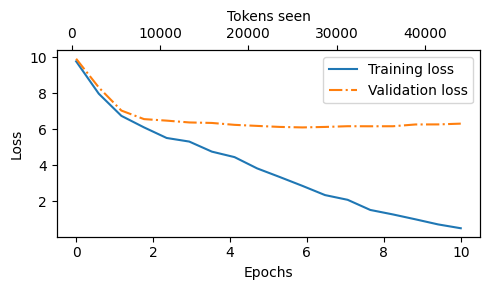

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

### 5.3 Decoding strategies to control randomness

In [48]:
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [49]:
vocab = {
    'closer':0,
    'every':1,
    'effort':2,
    'forward':3,
    'inches':4,
    'moves':5,
    'pizza':6,
    'toward':7,
    'you':8
}

inverse_vocab = {v:k for k, v in vocab.items()}

# Suppose input is 'every effort moves you' and the LLM
# returns the following logits for the next token
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows
print(inverse_vocab[next_token_id])

forward


In [50]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [51]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [52]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits/temperature
    return torch.softmax(scaled_logits, dim=0)


# Temperature values
temperatures = [1,0.1, 5] # original, higher confidence and lower confidence

# calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

AttributeError: 'Axes' object has no attribute 'set_xtickslabels'

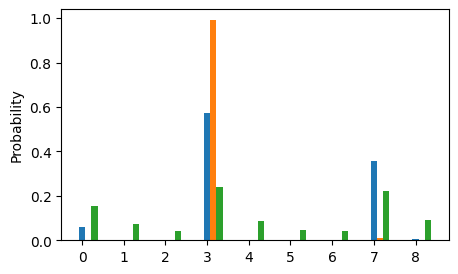

In [55]:
# ploting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+i*bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xtickslabels(vocab.keys(), rotation = 90)
ax.legend()

plt.tight_layout()
plt.savefig('temperature-plt.pdf')
plt.show()


In [56]:
print_sampled_tokens(scaled_probas[1])


0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you


### 5.3.2 Top-k sampling

In [57]:
top_k = 3
top_logits , top_pos = torch.topk(next_token_logits, top_k)

print('Top logits:', top_logits)
print('Top positions:', top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


### 5.3.3 Modifying the text generation functions

In [60]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k = None, eos_id = None):
    
    # For-loop is the same as before: get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1, :]

        # New: filter logits with top_k sampling
        if top_k is not None:
            # keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # applying temperature scaling
        if temperature >0.0:
            logits = logits/temperature

            # Apply softmax to get probablities
            probs = torch.softmax(logits, dim=-1) # (batch_size, context_len)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples =1) # ( batch_size, 1)
        
        # Otherwise same as before: get idx of the vocab entry with highest logits values
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) #(batch_size,1)
        
        if idx_next == eos_id: # stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        # same as before append samples index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) #(batch_size, num_token+1)
    
    return idx
        


In [61]:
torch.manual_seed(123)
token_idx = generate(
    model=model,
    idx = text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.4 Loading and saving model weights in pytorch

In [65]:
torch.save(model.state_dict(), 'model.pth')


In [66]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('model.pth', map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [70]:
# These adaptive optimizers store additional parameters for each model weights so it makes
# sence to save them as well in case we plan to continue the pretraing later
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict()
    },
    'model_and_optimizer.pth'
)
torch.save(model.state_dict(), 'model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')

In [72]:
# checkpoint = torch.load('model_and_optimizer.pth', weights_only=True)

# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
# optimizer.load_state_dict(torch.load(checkpoint['optimizer_state_dict']))
# model.train()
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('model.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(torch.load('optimizer.pth'))
model.eval()

C:\Users\hp\AppData\Local\Temp\ipykernel_14008\3683350445.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
C:\Users\hp\App

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### 5.5 Loading pretrained weights from OpenAI

In [73]:
file_name = 'gpt2-smaall-124M.pth'

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")
BASE_CONFIG = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 1024,  # Context length
        "drop_rate": 0.0,        # Dropout rate
        "qkv_bias": True         # Query-key-value bias
    }
NEW_CONFIG = GPT_CONFIG_124M.copy()
gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only = True))
gpt.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt.to(device)

torch.manual_seed(123)
tokens_ids = generate(
    model = gpt,
    idx = text_to_token_ids('Every effort moves you', tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG['context_lenght'],
    top_k = 50,
    temperature=1.5
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

HTTPError: HTTP Error 404: Not Found

In [ ]:
print("Tensorflow verison: ", version('tensorflow'))
print('tqdm version:', version('tqdm'))

NameError: name 'version' is not defined

In [77]:
from gpt_generate import download_and_load_gpt2


In [78]:
settings, params = download_and_load_gpt2(model_size="124M", model_dir="gpt2")
print("Settings:", settings)

HTTPError: HTTP Error 404: The specified blob does not exist.

In [ ]:
print("Parameter dictionary keys:", params.keys())


NameError: name 'params' is not defined

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

NameError: name 'params' is not defined

In [ ]:

# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);


In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

NameError: name 'torch' is not defined